In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
print(os.listdir())

['glove.6B.50d.txt', 'glove.6B.100d.txt', '=2.0.0', 'glove.6B.zip', 'glove.6B.300d.txt', 'glove.6B.200d.txt', 'glove.6B.zip.1', '.virtual_documents']


In [3]:
from sklearn.preprocessing import LabelBinarizer
sentences = ["I love NLP", "NLP is fun", "I love machine learning"]
words = set(" ".join(sentences).split())
word2idx = {word: idx for idx, word in enumerate(words)}
def one_hot_encode(sentence):
    encoding = []
    for word in sentence.split():
        vec = [0] * len(words)
        vec[word2idx[word]] = 1
        encoding.append(vec)
    return encoding
for s in sentences:
    print(f"Sentence: {s}")
    print(f"One-hot: {one_hot_encode(s)}\n")

Sentence: I love NLP
One-hot: [[0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0]]

Sentence: NLP is fun
One-hot: [[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 0]]

Sentence: I love machine learning
One-hot: [[0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1]]



TF-IDF Table:
        fun        is  learning      love   machine       nlp
0  0.000000  0.000000  0.000000  0.707107  0.000000  0.707107
1  0.622766  0.622766  0.000000  0.000000  0.000000  0.473630
2  0.000000  0.000000  0.622766  0.473630  0.622766  0.000000


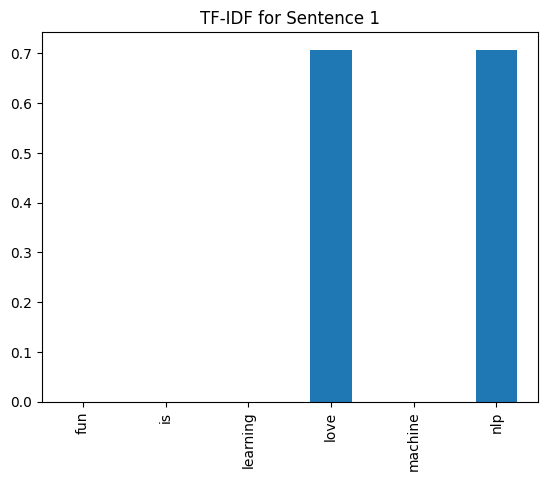

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sentences)
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print("TF-IDF Table:")
print(df)
df.iloc[0].plot(kind='bar', title="TF-IDF for Sentence 1")
plt.show()

In [5]:
from gensim.models import Word2Vec
tokenized = [s.lower().split() for s in sentences]
cbow_model = Word2Vec(sentences=tokenized, vector_size=50, window=2, min_count=1, sg=0)
sg_model = Word2Vec(sentences=tokenized, vector_size=50, window=2, min_count=1, sg=1)

In [6]:
similarity = cbow_model.wv.similarity('nlp', 'love')
print("CBOW similarity (nlp, love):", similarity)

similarity = sg_model.wv.similarity('nlp', 'love')
print("Skip-gram similarity (nlp, love):", similarity)

CBOW similarity (nlp, love): 0.011071973
Skip-gram similarity (nlp, love): 0.011071973


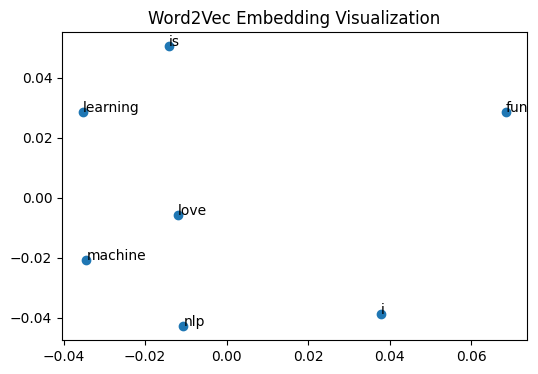

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def plot_embeddings(model):
    words = list(model.wv.key_to_index.keys())
    X = model.wv[words]
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    plt.figure(figsize=(6,4))
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.title("Word2Vec Embedding Visualization")
    plt.show()
plot_embeddings(cbow_model)

In [8]:
glove_path = "glove.6B.50d.txt"
glove = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = list(map(float, values[1:]))
        glove[word] = vector
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def find_similar(word, top_n=5):
    if word not in glove:
        print(f"'{word}' not in vocabulary.")
        return
    word_vec = np.array(glove[word]).reshape(1, -1)
    similarities = {w: cosine_similarity([vec], word_vec)[0][0] for w, vec in glove.items()}
    similar = sorted(similarities.items(), key=lambda item: item[1], reverse=True)[1:top_n+1]
    print(f"Top {top_n} similar words to '{word}':")
    for word, score in similar:
        print(f"{word}: {score:.4f}")
find_similar("king")

Top 5 similar words to 'king':
prince: 0.8236
queen: 0.7839
ii: 0.7746
emperor: 0.7736
son: 0.7667


In [9]:
from gensim.models import FastText
fasttext_model = FastText(sentences=tokenized, vector_size=50, window=2, min_count=1)
similar_words = fasttext_model.wv.most_similar("nlp")
print("Words similar to 'nlp' using FastText:", similar_words)

Words similar to 'nlp' using FastText: [('i', 0.09283863753080368), ('is', -0.020471520721912384), ('fun', -0.07955582439899445), ('learning', -0.08168100565671921), ('love', -0.15205414593219757), ('machine', -0.18885096907615662)]


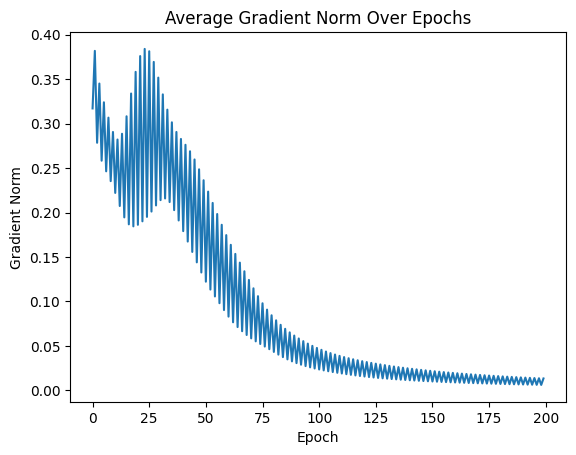

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
data = ["hello", "world"]
chars = sorted(list(set("".join(data))))
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for ch, i in char2idx.items()}
def one_hot_seq(seq):
    return torch.eye(len(chars))[torch.tensor([char2idx[c] for c in seq])]
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, hn = self.rnn(x)
        out = self.fc(out)
        return out
input_size = len(chars)
hidden_size = 8
output_size = len(chars)
model = SimpleRNN(input_size, hidden_size, output_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
grad_norms = []
for epoch in range(100):
    total_loss = 0
    model.zero_grad()
    for word in data:
        x = one_hot_seq(word[:-1]).unsqueeze(0)
        y = torch.tensor([char2idx[c] for c in word[1:]])
        output = model(x).squeeze(0)
        loss = loss_fn(output, y)
        loss.backward()
        total_grad_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)
        grad_norms.append(total_grad_norm / len(list(model.parameters())))
        optimizer.step()
plt.plot(grad_norms)
plt.title("Average Gradient Norm Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.show()

Epoch 1, Loss: 0.0661, Accuracy: 0.9690
Epoch 2, Loss: 0.0007, Accuracy: 1.0000
Epoch 3, Loss: 0.0005, Accuracy: 1.0000
Epoch 4, Loss: 0.0004, Accuracy: 1.0000
Epoch 5, Loss: 0.0003, Accuracy: 1.0000


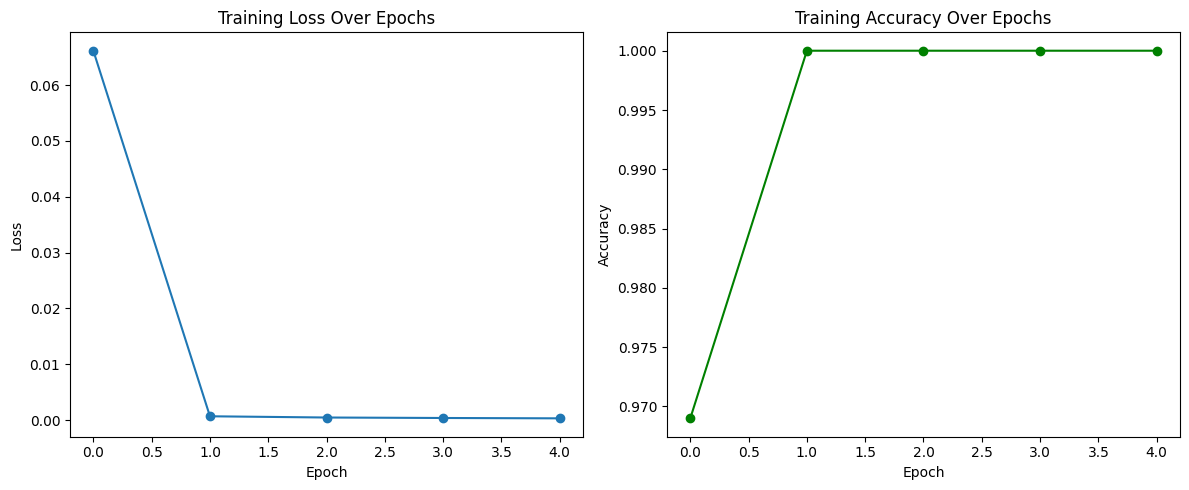

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
    for label, text in data_iter:
        yield tokenizer(text)
train_iter, test_iter = IMDB(split=('train', 'test'))
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
def collate_batch(batch):
    label_map = {'pos': 1, 'neg': 0}
    text_list, label_list = [], []
    for label, text in batch:
        tokens = tokenizer(text)
        ids = torch.tensor(vocab(tokens), dtype=torch.long)
        text_list.append(ids)
        label_list.append(torch.tensor(label if isinstance(label, int) else label_map[label], dtype=torch.long))
    text_list = pad_sequence(text_list, batch_first=True)
    return text_list, torch.tensor(label_list)
train_iter, test_iter = IMDB(split=('train', 'test'))
train_loader = DataLoader(list(train_iter)[:1000], batch_size=32, collate_fn=collate_batch)
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.embed(x)
        _, h = self.rnn(x)
        return self.fc(h.squeeze(0))
model = RNNClassifier(len(vocab), 64, 128, 2)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []
train_accuracies = []
for epoch in range(5):
    total_loss = 0
    correct = 0
    total = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(output, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green')
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


Training LSTM...
[LSTM] Epoch 1: Loss = 0.0713, Accuracy = 0.9990
[LSTM] Epoch 2: Loss = 0.0004, Accuracy = 1.0000
[LSTM] Epoch 3: Loss = 0.0002, Accuracy = 1.0000
[LSTM] Epoch 4: Loss = 0.0002, Accuracy = 1.0000
[LSTM] Epoch 5: Loss = 0.0001, Accuracy = 1.0000

Training GRU...
[GRU] Epoch 1: Loss = 0.0668, Accuracy = 0.9910
[GRU] Epoch 2: Loss = 0.0012, Accuracy = 1.0000
[GRU] Epoch 3: Loss = 0.0003, Accuracy = 1.0000
[GRU] Epoch 4: Loss = 0.0003, Accuracy = 1.0000
[GRU] Epoch 5: Loss = 0.0002, Accuracy = 1.0000


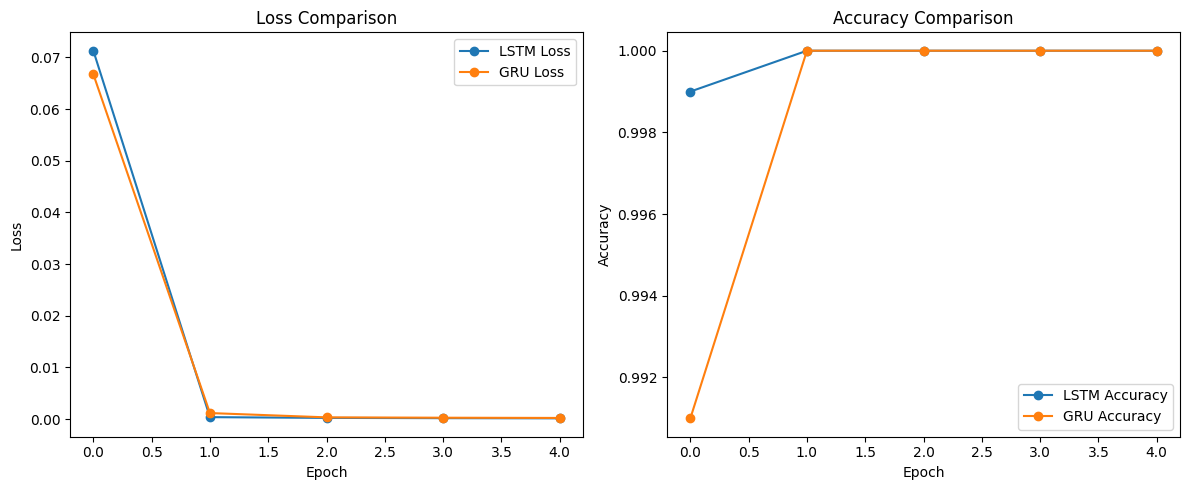


LSTM training time: 412.49s
GRU training time: 278.96s


In [17]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
    for label, text in data_iter:
        yield tokenizer(text)
train_iter, _ = IMDB(split=('train', 'test'))
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
def collate_batch(batch):
    label_map = {'pos': 1, 'neg': 0}
    text_list, label_list = [], []
    for label, text in batch:
        tokens = tokenizer(text)
        ids = torch.tensor(vocab(tokens), dtype=torch.long)
        text_list.append(ids)
        if isinstance(label, str):
            label = label_map[label]
        label_list.append(torch.tensor(label, dtype=torch.long))
    text_list = pad_sequence(text_list, batch_first=True)
    return text_list, torch.tensor(label_list)
train_iter, _ = IMDB(split=('train', 'test'))
train_loader = DataLoader(list(train_iter)[:1000], batch_size=32, collate_fn=collate_batch)
class RNNBase(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size, model_type='LSTM'):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        else:
            self.rnn = nn.GRU(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.embed(x)
        _, h = self.rnn(x)
        if isinstance(h, tuple):  # LSTM returns (h_n, c_n)
            h = h[0]
        return self.fc(h.squeeze(0))
def train_model(model_type='LSTM'):
    model = RNNBase(len(vocab), 64, 128, 2, model_type)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    losses = []
    accuracies = []
    start = time.time()
    for epoch in range(5):
        total_loss = 0
        correct = 0
        total = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
        losses.append(total_loss / len(train_loader))
        accuracies.append(correct / total)
        print(f"[{model_type}] Epoch {epoch+1}: Loss = {losses[-1]:.4f}, Accuracy = {accuracies[-1]:.4f}")
    duration = time.time() - start
    return losses, accuracies, duration
print("\nTraining LSTM...")
lstm_losses, lstm_accuracies, lstm_time = train_model('LSTM')
print("\nTraining GRU...")
gru_losses, gru_accuracies, gru_time = train_model('GRU')
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_losses, label='LSTM Loss', marker='o')
plt.plot(gru_losses, label='GRU Loss', marker='o')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(lstm_accuracies, label='LSTM Accuracy', marker='o')
plt.plot(gru_accuracies, label='GRU Accuracy', marker='o')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
print(f"\nLSTM training time: {lstm_time:.2f}s")
print(f"GRU training time: {gru_time:.2f}s")

Epoch 1, Loss: 3.0218
Epoch 2, Loss: 2.3364
Epoch 3, Loss: 1.7168
Epoch 4, Loss: 1.1424
Epoch 5, Loss: 0.6992
Epoch 6, Loss: 0.4194
Epoch 7, Loss: 0.2721
Epoch 8, Loss: 0.1995
Epoch 9, Loss: 0.1597
Epoch 10, Loss: 0.1350
Epoch 11, Loss: 0.1205
Epoch 12, Loss: 0.1100
Epoch 13, Loss: 0.1024
Epoch 14, Loss: 0.0965
Epoch 15, Loss: 0.0917


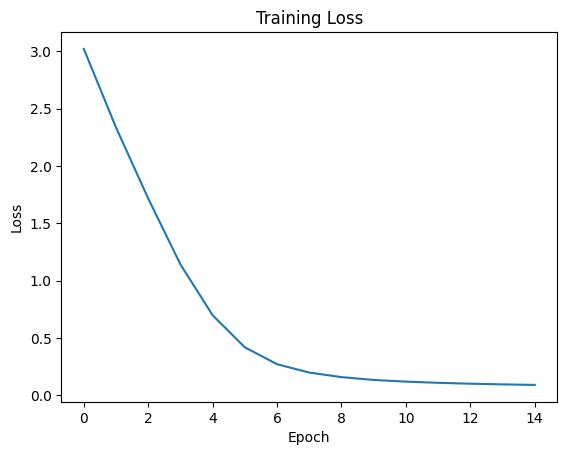


Generated Text:
To be, or not to be, that is the question:
Whether 'tis nobler is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of ourtune,
Or to take arms agais nd arrows of outrageous fortune,
Or to take arms against a sea of troubles
And by opposing end that is the question:
Whether 'tis no


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
text = (
    "To be, or not to be, that is the question:\n"
    "Whether 'tis nobler in the mind to suffer\n"
    "The slings and arrows of outrageous fortune,\n"
    "Or to take arms against a sea of troubles\n"
    "And by opposing end them."
)
chars = sorted(set(text))
char2idx = {ch: idx for idx, ch in enumerate(chars)}
idx2char = {idx: ch for ch, idx in char2idx.items()}
vocab_size = len(chars)
def encode_text(txt):
    return [char2idx[ch] for ch in txt]
def decode_text(indices):
    return ''.join([idx2char[idx] for idx in indices])
encoded = encode_text(text)
seq_len = 40  # sequence length for input
def get_batches(encoded, batch_size):
    inputs, targets = [], []
    for i in range(len(encoded) - seq_len):
        x_seq = encoded[i:i+seq_len]
        y_seq = encoded[i+1:i+seq_len+1]
        inputs.append(torch.tensor(x_seq))
        targets.append(torch.tensor(y_seq))
    dataset = list(zip(inputs, targets))
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden
model = CharLSTM(vocab_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
train_loader = get_batches(encoded, batch_size=16)
losses = []
for epoch in range(15):
    total_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        out, _ = model(x)
        out = out.view(-1, vocab_size)
        y = y.view(-1)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss / len(train_loader))
    print(f"Epoch {epoch + 1}, Loss: {losses[-1]:.4f}")
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
def generate_text(model, start_text, length=200):
    model.eval()
    input_seq = torch.tensor([char2idx[ch] for ch in start_text], dtype=torch.long).unsqueeze(0)
    hidden = None
    generated = list(start_text)
    with torch.no_grad():
        for _ in range(length):
            out, hidden = model(input_seq, hidden)
            last_logits = out[:, -1, :]
            probs = torch.softmax(last_logits, dim=-1).squeeze()
            char_idx = torch.multinomial(probs, 1).item()
            generated.append(idx2char[char_idx])
            input_seq = torch.tensor([[char_idx]], dtype=torch.long)
    return ''.join(generated)
print("\nGenerated Text:")
print(generate_text(model, start_text="To be, or ", length=300))

Training Standard LSTM
Epoch 1: Loss=0.1106, Accuracy=0.9540
Epoch 2: Loss=0.0006, Accuracy=1.0000
Epoch 3: Loss=0.0004, Accuracy=1.0000
Epoch 4: Loss=0.0003, Accuracy=1.0000
Epoch 5: Loss=0.0002, Accuracy=1.0000

Training Bidirectional LSTM
Epoch 1: Loss=0.1088, Accuracy=0.9690
Epoch 2: Loss=0.0000, Accuracy=1.0000
Epoch 3: Loss=0.0000, Accuracy=1.0000
Epoch 4: Loss=0.0000, Accuracy=1.0000
Epoch 5: Loss=0.0000, Accuracy=1.0000


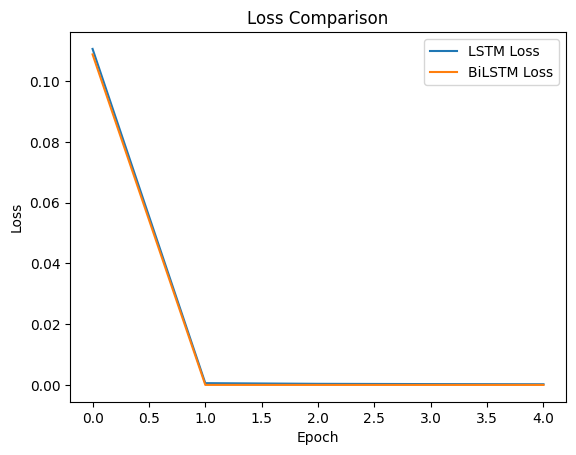

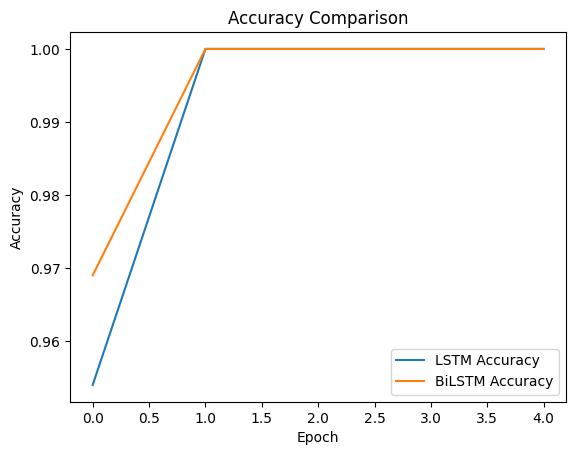

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
    for label, text in data_iter:
        yield tokenizer(text)
train_iter_for_vocab, _ = IMDB(split=('train', 'test'))
vocab = build_vocab_from_iterator(yield_tokens(train_iter_for_vocab), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
label_map = {'pos': 1, 'neg': 0}
def collate_batch(batch):
    text_list, label_list = [], []
    for label, text in batch:
        if isinstance(label, int):
            label_id = label
        else:  
            label_id = label_map[label]
        tokens = tokenizer(text)
        ids = torch.tensor(vocab(tokens), dtype=torch.long)
        text_list.append(ids)
        label_list.append(torch.tensor(label_id, dtype=torch.long))
    text_list = pad_sequence(text_list, batch_first=True)
    label_list = torch.tensor(label_list)
    return text_list, label_list
train_iter, test_iter = IMDB(split=('train', 'test'))
train_loader = DataLoader(list(train_iter)[:1000], batch_size=32, collate_fn=collate_batch)
test_loader = DataLoader(list(test_iter)[:500], batch_size=32, collate_fn=collate_batch)
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        embedded = self.embed(x)
        _, (hidden, _) = self.lstm(embedded)
        return self.fc(hidden[-1])
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, x):
        embedded = self.embed(x)
        _, (hidden, _) = self.lstm(embedded)
        h = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(h)
def train_model(model, train_loader, epochs=5):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, train_accuracies = [], []
    for epoch in range(epochs):
        total_loss = 0
        correct, total = 0, 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
        acc = correct / total
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(acc)
        print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f}, Accuracy={acc:.4f}")
    return train_losses, train_accuracies
print("Training Standard LSTM")
lstm_model = LSTMClassifier(len(vocab), 64, 128, 2)
lstm_losses, lstm_accs = train_model(lstm_model, train_loader)
print("\nTraining Bidirectional LSTM")
bilstm_model = BiLSTMClassifier(len(vocab), 64, 128, 2)
bilstm_losses, bilstm_accs = train_model(bilstm_model, train_loader)
plt.plot(lstm_losses, label='LSTM Loss')
plt.plot(bilstm_losses, label='BiLSTM Loss')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(lstm_accs, label='LSTM Accuracy')
plt.plot(bilstm_accs, label='BiLSTM Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()